In [1]:
%cd drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [2]:
# train_networks: Training CNNs to be used by the main program

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import imutils
import processing

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage.morphology import watershed, disk
from skimage.feature import peak_local_max
from skimage.filters import meijering

from scipy import ndimage as ndi


def plot_two_images(imgL, imgR, titleL, titleR):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(imgL, cmap='gray')
    plt.title(titleL)
    f.add_subplot(1,2, 2)
    plt.imshow(imgR, cmap='gray')
    plt.title(titleR)
    plt.show(block=True)
    
def load_data(dataset):
    """
    Returns a list of dictionaries containing an image and the corresponding mask
    """
    data = []
    paths = [dataset + '/Sequence 1', dataset + '/Sequence 2']
    for path in paths:
        mask_path = path + ' Masks'
        for f in os.listdir(mask_path):
            if not f.endswith(".tif"):
                continue
            image = cv2.imread(os.path.join(path, f.replace('mask', '')), cv2.IMREAD_GRAYSCALE)
            image = preprocessing.equalize_clahe(image).astype(np.float32)
            mask = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED)
            print("   Loaded " + os.path.join(mask_path, f) + ", " + os.path.join(path, f.replace('mask', '')))
            
            # Generate the Cell Mask and Markers from the Mask
            cell_mask = (mask > 0).astype(np.uint8)
            markers = (preprocessing.get_markers(mask) > 0).astype(np.uint8)
            weight_map = preprocessing.get_weight_map(markers)
            
            # Pack the data for the DataLoader
            target = (cell_mask, markers, weight_map)
            data.append((np.array([image]), target))
            
    return DataLoader(data, batch_size=9, shuffle=True)

In [3]:
# Class for creating the CNN
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv7 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv9 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv11 = nn.Conv2d(768, 256, 3, padding=1)
        self.conv12 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv13 = nn.Conv2d(384, 128, 3, padding=1)
        self.conv14 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv15 = nn.Conv2d(192, 64, 3, padding=1)
        self.conv16 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv17 = nn.Conv2d(96, 32, 3, padding=1)
        self.conv18 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv_out = nn.Conv2d(32, 2, 1)
        
    def forward(self, x):
        """
        Forward pass through the network
        """
        x = F.relu(self.conv1(x))
        contraction_32 = F.relu(self.conv2(x))
        
        x = F.max_pool2d(contraction_32, kernel_size=2)
        x = F.relu(self.conv3(x))
        contraction_64 = F.relu(self.conv4(x))
        
        x = F.max_pool2d(contraction_64, kernel_size=2)
        x = F.relu(self.conv5(x))
        contraction_128 = F.relu(self.conv6(x))
        
        x = F.max_pool2d(contraction_128, kernel_size=2)
        x = F.relu(self.conv7(x))
        contraction_256 = F.relu(self.conv8(x))
        
        x = F.max_pool2d(contraction_256, kernel_size=2)
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_256, x), dim=1)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_128, x), dim=1)
        x = F.relu(self.conv13(x))
        x = F.relu(self.conv14(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_64, x), dim=1)
        x = F.relu(self.conv15(x))
        x = F.relu(self.conv16(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = torch.cat((contraction_32, x), dim=1)
        x = F.relu(self.conv17(x))
        x = F.relu(self.conv18(x))
        
        x = self.conv_out(x)
        output = F.log_softmax(x, dim=1)
        return output

"""
def weighted_cross_entropy_loss(inputs, targets, weights):

    Weighted Cross-Entropy Loss takes in a weight map
    and computes loss

    device = torch.device("cpu")
    inputs = inputs.to(device)
    targets = targets.to(device)
    weights = weights.to(device)
    loss = torch.zeros(inputs.shape[0])

    # Calculate loss for each sample in the batch
    for sample in range(inputs.shape[0]):
        print("Sample", sample+1)
        sample_loss, total_weight = 0.0, 0.0
        for row in range(inputs.shape[2]):
            for col in range(inputs.shape[3]):
                # Get pixel q
                q = (row, col)
                w = weights[sample][q].item()
                total_weight += w
                if targets[sample][0][q] == 0:
                    # Get predicted probability for q = 0
                    p = inputs[sample][0][q]
                else:
                    # Get predicted probability for q = 1
                    p = inputs[sample][1][q]
                sample_loss -= w * torch.log(p).item()
        sample_loss = sample_loss / total_weight
        loss[sample] = sample_loss

    return torch.mean(loss)
"""

def main():
    """
    Train 2 networks for predicting markers and the cell mask respectively
    Set trains on data from "Sequence 1 Masks" and "Sequence 2 Masks"
    and save the models
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device: " + str(device))
    
    # Net M predicts the markers. Net C predicts the cell mask
    net_m, net_c = Network().to(device), Network().to(device)
    
    criterion = F.nll_loss
    
    # Optimising using Adam algorithm
    optimiser_m = optim.Adam(net_m.parameters(), lr=0.001)
    optimiser_c = optim.Adam(net_c.parameters(), lr=0.001)
    
    # Iterate over a number of epochs on the data
    for epoch in range(100):
        for i, batch in enumerate(trainLoader):
            x = batch[0].to(device)
            target = batch[1]
            cell_masks, markers = target[0].to(device), target[1].to(device) # Unpack target data
            weight_map = target[2].to(device)

            # Clear gradients from last step
            optimiser_m.zero_grad()
            optimiser_c.zero_grad()

            # Predict the markers from the image
            output_m = net_m(x)
            loss_m = criterion(output_m, markers.long())
            loss_m.backward()
            optimiser_m.step()
            
            # Predict the Cell Mask from the image
            output_c = net_c(x)
            loss_c = criterion(output_c, cell_masks.long())
            loss_c.backward()
            optimiser_c.step()

            if epoch == 0 or (epoch + 1) % 10 == 0:
                print(f"Epoch: {epoch+1}, Batch: {i + 1}")
                print(f"Cell Mask Loss: {loss_c.item():.2f}, Markers Loss: {loss_m.item():.2f}")
                
                plt.imshow(x[0][0].cpu(), cmap='gray')
                plt.title("Input")
                plt.show()

                # Get the predicted Cell Mask and Markers for one of the images
                pred_c = torch.argmax(output_c[0], dim=0).cpu()
                pred_m = torch.argmax(output_m[0], dim=0).cpu()
                
                # Compare predicted to true images
                plot_two_images(pred_c, cell_masks[0].cpu(), "Predicted Cell Mask", "True Cell Mask")
                plot_two_images(pred_m, markers[0].cpu(), "Predicted Markers", "True Markers")

    torch.save(net_m.state_dict(), "./CNN_m.pth")
    torch.save(net_c.state_dict(), "./CNN_c.pth")
    print("Saved models.")

In [4]:
print("Loading Data...")
trainLoader = load_data('DIC-C2DH-HeLa')
print("Finished.")

Loading Data...
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t002mask.tif, DIC-C2DH-HeLa/Sequence 1/t002.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t031mask.tif, DIC-C2DH-HeLa/Sequence 1/t031.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t005mask.tif, DIC-C2DH-HeLa/Sequence 1/t005.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t021mask.tif, DIC-C2DH-HeLa/Sequence 1/t021.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t034mask.tif, DIC-C2DH-HeLa/Sequence 1/t034.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t067mask.tif, DIC-C2DH-HeLa/Sequence 1/t067.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t054mask.tif, DIC-C2DH-HeLa/Sequence 1/t054.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t039mask.tif, DIC-C2DH-HeLa/Sequence 1/t039.tif
   Loaded DIC-C2DH-HeLa/Sequence 1 Masks/t033mask.tif, DIC-C2DH-HeLa/Sequence 1/t033.tif
   Loaded DIC-C2DH-HeLa/Sequence 2 Masks/t061mask.tif, DIC-C2DH-HeLa/Sequence 2/t061.tif
   Loaded DIC-C2DH-HeLa/Sequence 2 Masks/t027mask.tif, DIC-C2DH-HeLa/Sequence 2/t027.tif
   Lo

Using device: cuda:0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch: 1, Batch: 1
Cell Mask Loss: 0.69, Markers Loss: 0.42


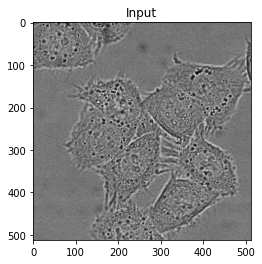

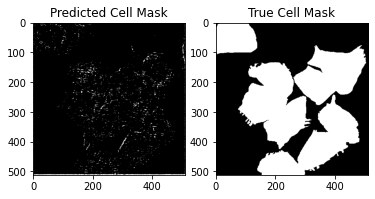

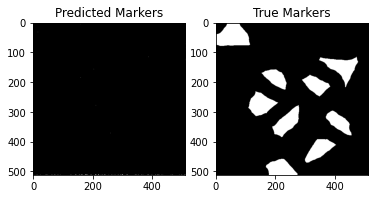

Epoch: 1, Batch: 2
Cell Mask Loss: 1.71, Markers Loss: 0.95


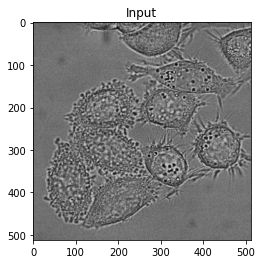

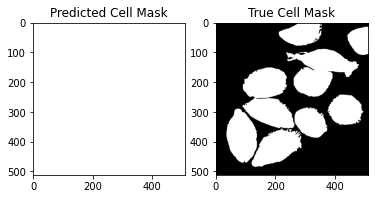

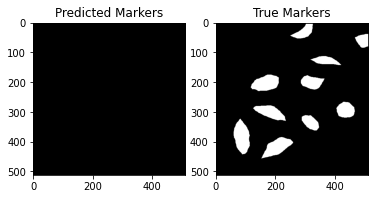

Epoch: 10, Batch: 1
Cell Mask Loss: 0.66, Markers Loss: 0.42


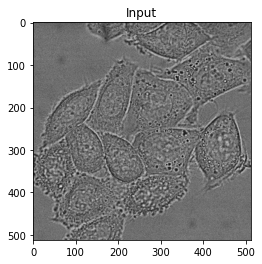

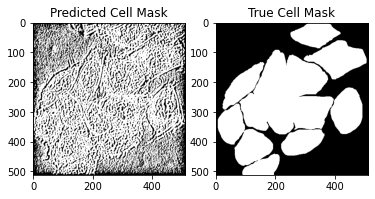

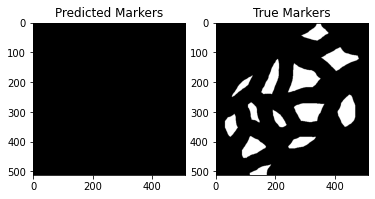

Epoch: 10, Batch: 2
Cell Mask Loss: 0.66, Markers Loss: 0.43


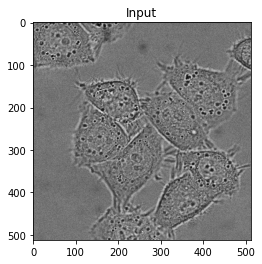

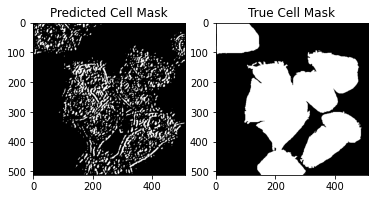

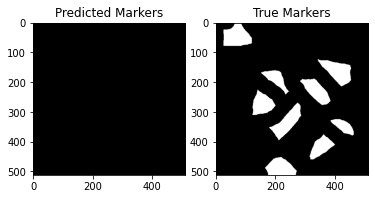

Epoch: 20, Batch: 1
Cell Mask Loss: 0.65, Markers Loss: 0.41


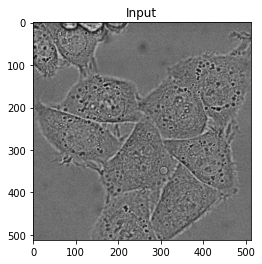

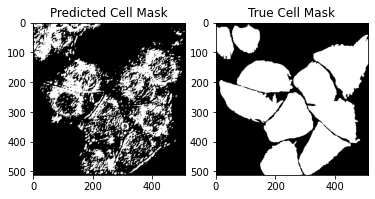

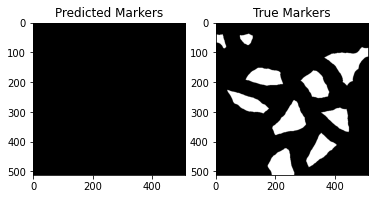

Epoch: 20, Batch: 2
Cell Mask Loss: 0.61, Markers Loss: 0.43


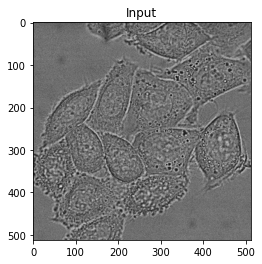

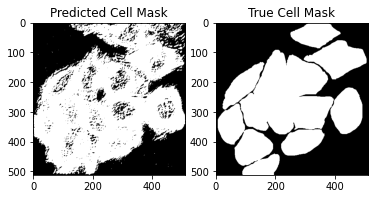

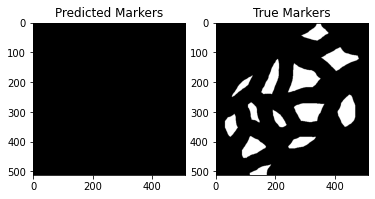

Epoch: 30, Batch: 1
Cell Mask Loss: 0.66, Markers Loss: 0.45


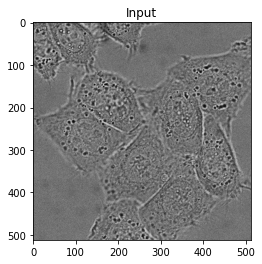

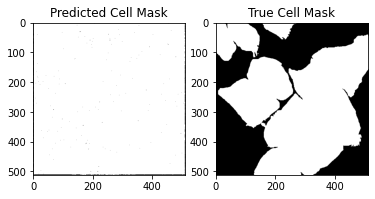

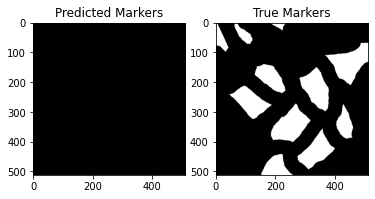

Epoch: 30, Batch: 2
Cell Mask Loss: 0.71, Markers Loss: 0.39


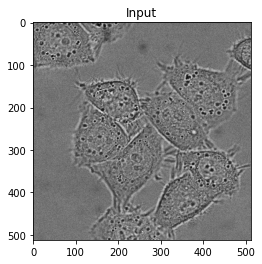

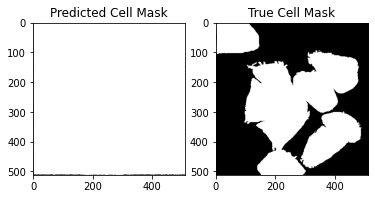

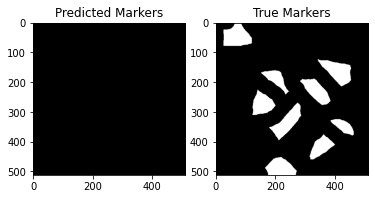

Epoch: 40, Batch: 1
Cell Mask Loss: 0.48, Markers Loss: 0.40


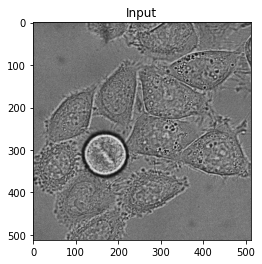

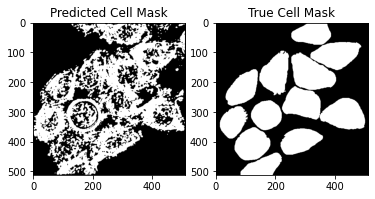

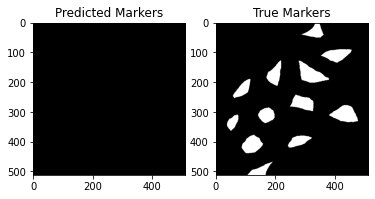

Epoch: 40, Batch: 2
Cell Mask Loss: 0.64, Markers Loss: 0.41


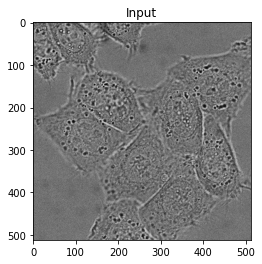

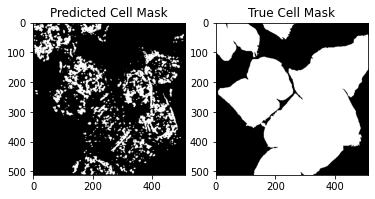

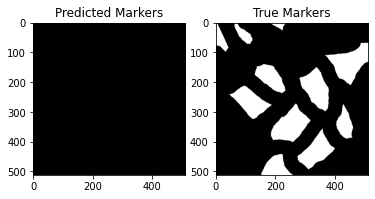

Epoch: 50, Batch: 1
Cell Mask Loss: 0.47, Markers Loss: 0.38


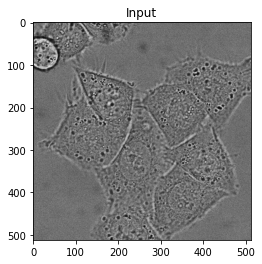

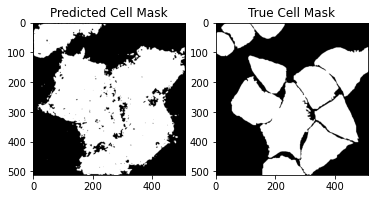

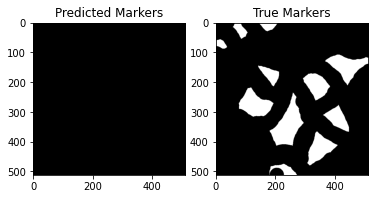

Epoch: 50, Batch: 2
Cell Mask Loss: 0.42, Markers Loss: 0.42


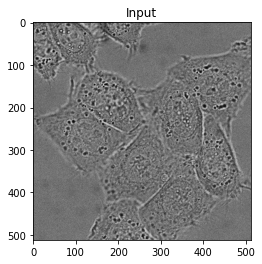

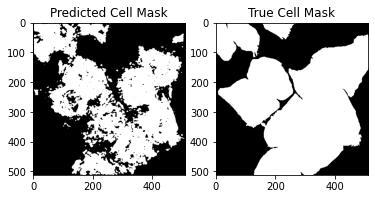

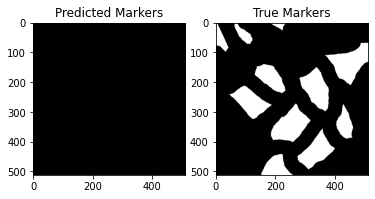

Epoch: 60, Batch: 1
Cell Mask Loss: 0.44, Markers Loss: 0.39


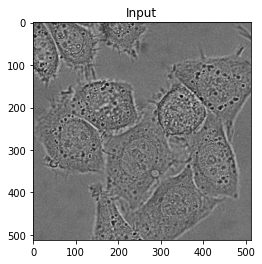

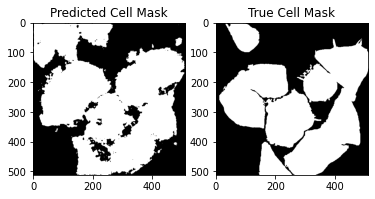

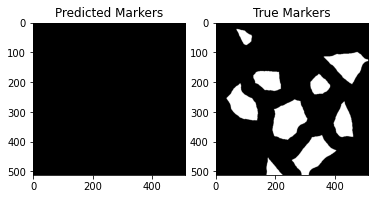

Epoch: 60, Batch: 2
Cell Mask Loss: 0.40, Markers Loss: 0.39


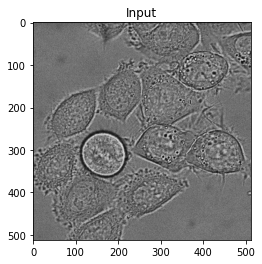

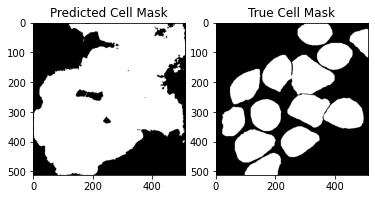

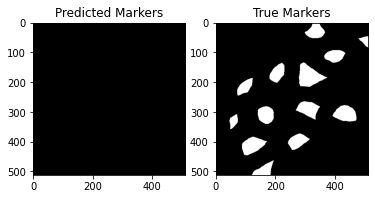

Epoch: 70, Batch: 1
Cell Mask Loss: 0.43, Markers Loss: 0.36


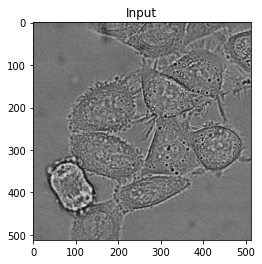

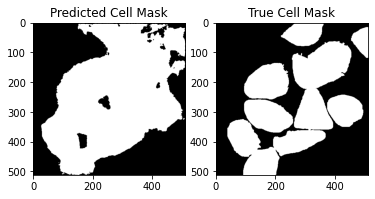

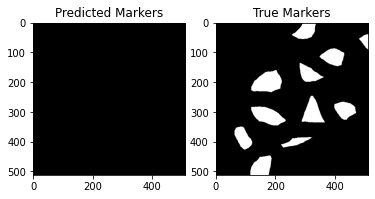

Epoch: 70, Batch: 2
Cell Mask Loss: 0.38, Markers Loss: 0.41


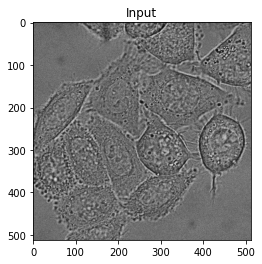

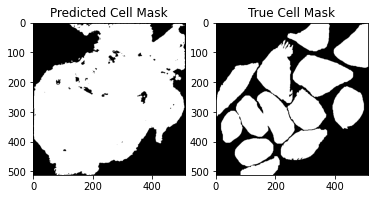

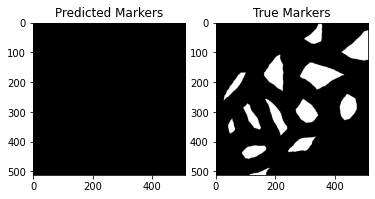

Epoch: 80, Batch: 1
Cell Mask Loss: 0.43, Markers Loss: 0.36


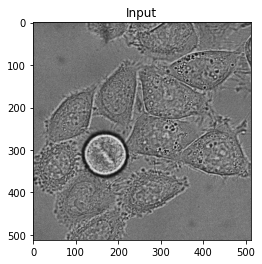

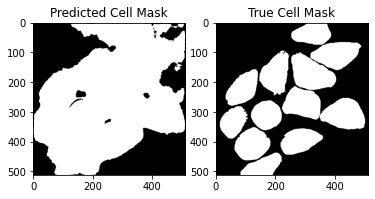

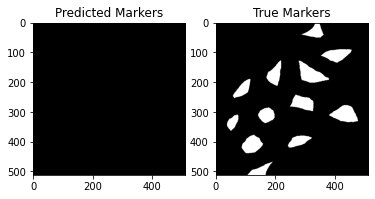

Epoch: 80, Batch: 2
Cell Mask Loss: 0.39, Markers Loss: 0.38


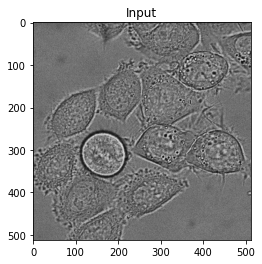

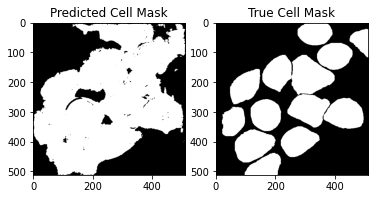

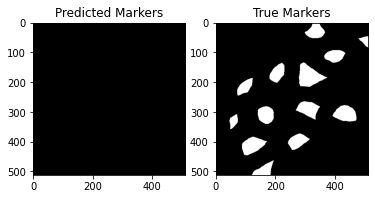

Epoch: 90, Batch: 1
Cell Mask Loss: 0.38, Markers Loss: 0.41


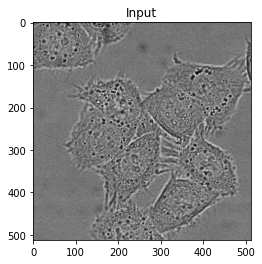

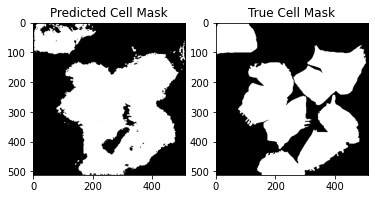

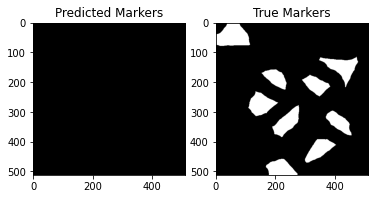

Epoch: 90, Batch: 2
Cell Mask Loss: 0.49, Markers Loss: 0.36


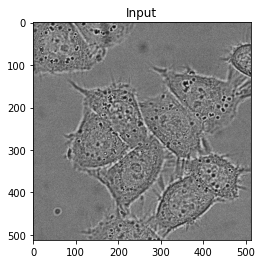

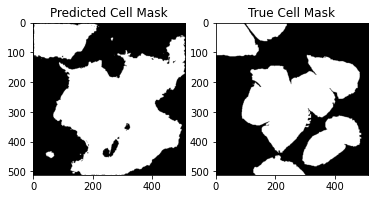

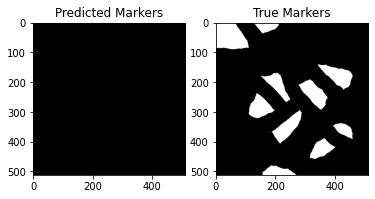

Epoch: 100, Batch: 1
Cell Mask Loss: 0.41, Markers Loss: 0.30


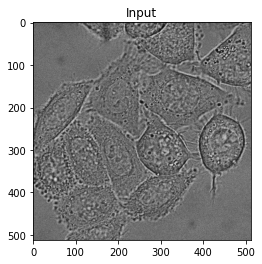

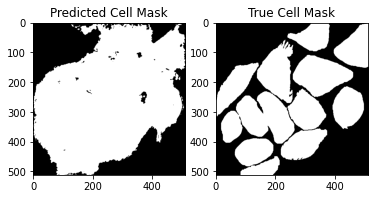

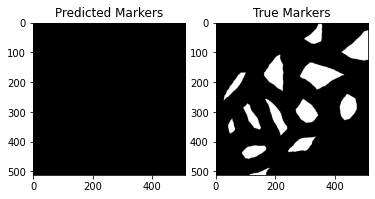

Epoch: 100, Batch: 2
Cell Mask Loss: 0.40, Markers Loss: 0.31


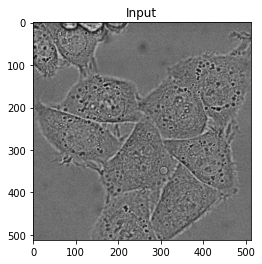

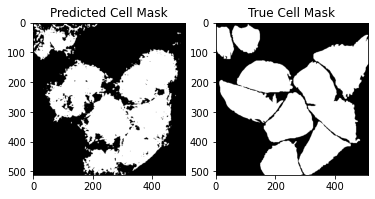

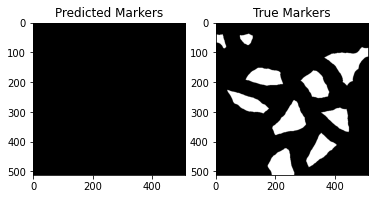

Saved models.


In [5]:
if __name__ == '__main__':
    main()